# Introduction

This notebook trains a linear discriminant analysis model on preprocessed EEG data to predict behavioral data from neural features.

An example of this can be found in the paper, "Human stereoEEG recordings reveal network dynamics of decision-making in a rule-switching task" by Wal et al.

Behavioral data and preprocessed neural data from Subject 06 in the NCSL EFRI datasetwill be used in this notebook.

# Setup

## Imports

In [1]:
import h5py 
import mat73
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Load File Paths

In [2]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
subs = ['18']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
        # 'data_path': ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject{sub}_snapshot_normalized.npy', # movement onset as event
        'data_path' : ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/show-card_pre-2sec_post-4sec/Subject{sub}_snapshot_normalized.npy', # visual cue as event
        'out_path_metrics': f'Metrics/Subject{sub}',
        'out_path_plots': f'Plots/Subject{sub}'
    }

In [3]:
raw_file = h5py.File(file_paths['18']['raw_path'])
setup_data = mat73.loadmat(file_paths['18']['setup_path'])

out_path_plots = file_paths['18']['out_path_plots']
out_path_metrics = file_paths['18']['out_path_metrics']

In [5]:
print(setup_data['elec_name'][170])
print(setup_data['elec_name'][99])
print(setup_data['elec_name'][101])

TP'10
B'13
B'11


In [4]:
setup_data.keys()

dict_keys(['elec_area', 'elec_ind', 'elec_name', 'filters', 'trial_times', 'trial_words'])

## Instantiate variables

In [5]:
bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(bets) == False)[0] # extract indices of trials without the 'nan'

bets = bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

In [6]:
# Trying to predict card value from neural data

card_categories = []
trials_to_keep = []

for i, card in enumerate(subject_cards):
    if card == 2:
        card_categories.append(0)
        trials_to_keep.append(i)
    elif card == 10:
        card_categories.append(1)
        trials_to_keep.append(i)

card_categories = np.asarray(card_categories)

data = np.load(file_paths['07']['data_path'])[trials_to_keep,:,:,40:100] # 40:100 is the time window of interest for visual cue as event

In [7]:
elec_names = np.array(setup_data['elec_name'])
elec_areas = np.array(setup_data['elec_area'])

In [ ]:
data = np.load(file_paths['18']['data_path'])[:,:,:,:60] # 0:60 is the time window of interest for movement onset as event
y = np.asarray([(0 if bet == 5 else 1) for bet in bets]) # 0 = low bet ($5), 1 = high bet ($20)

## Matplotlib Settings

In [8]:
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 22

## Create Frequency Bands

In [9]:
wavelet_freqs = np.logspace(np.log2(2),np.log2(150),num=63,base=2)

frequency_band_indices ={
    "Delta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 0.5 and freq < 4],
    "Theta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 4 and freq < 8],
    "Alpha" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 8 and freq < 14],
    "Beta" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 14 and freq < 30],
    "Gamma" : [i for i,freq in enumerate(wavelet_freqs) if freq >= 30]
}

In [10]:
f_band_data = np.zeros((data.shape[0], data.shape[1], 5, data.shape[3]))

for i, key in enumerate(frequency_band_indices):
    f_band_data[:,:,i,:] = data[:,:,frequency_band_indices[key],:].mean(2)

# Model Training

In [11]:
from logistic_regression import TrainOptimalTimeWindows

clf = TrainOptimalTimeWindows(data=f_band_data, setup_data=setup_data)

In [12]:
filtered_num_channels = clf.filter_channels()[2]

In [13]:
clf.train_on_optimal_time_windows(f_band_data, card_categories, n_processes=20, n_channels=filtered_num_channels)

Channel 17 done
Channel 92 done
Channel 103 done
Channel 75 done
Channel 124 done
Channel 16 done
Channel 42 done
Channel 18 done
Channel 122 done
Channel 68 done
Channel 129 done
Channel 22 done
Channel 101 done
Channel 88 done
Channel 58 done
Channel 12 done
Channel 39 done
Channel 35 done
Channel 95 done
Channel 97 done
Channel 109 done
Channel 51 done
Channel 119 done
Channel 104 done
Channel 67 done
Channel 33 done
Channel 93 done
Channel 43 done
Channel 89 done
Channel 13 done
Channel 37 done
Channel 125 done
Channel 77 done
Channel 59 done
Channel 38 done
Channel 54 done
Channel 21 done
Channel 7 done
Channel 36 done
Channel 27 done
Channel 99 done
Channel 105 done
Channel 69 done
Channel 49 done
Channel 3 done
Channel 52 done
Channel 61 done
Channel 29 done
Channel 102 done
Channel 34 done
Channel 14 done
Channel 62 done
Channel 74 done
Channel 28 done
Channel 45 done
Channel 19 done
Channel 94 done
Channel 9 done
Channel 128 done
Channel 44 done
Channel 32 done
Channel 123 don

In [14]:
clf._optimal_time_windows_per_channel

[[37, [26, 30], 0.8290909090909091],
 [54, [44, 48], 0.8127272727272727],
 [94, [56, 60], 0.7981818181818181],
 [123, [22, 26], 0.7945454545454547],
 [35, [13, 13], 0.7727272727272727],
 [122, [29, 39], 0.7709090909090909],
 [8, [57, 59], 0.7581818181818181],
 [68, [23, 23], 0.7527272727272728],
 [62, [43, 53], 0.7418181818181818],
 [53, [56, 58], 0.74],
 [7, [28, 56], 0.738181818181818],
 [33, [9, 31], 0.7345454545454546],
 [67, [6, 26], 0.7218181818181819],
 [22, [7, 13], 0.72],
 [32, [9, 37], 0.72],
 [28, [47, 47], 0.7163636363636365],
 [12, [31, 35], 0.7163636363636364],
 [58, [44, 44], 0.7163636363636364],
 [38, [40, 54], 0.7163636363636363],
 [39, [9, 11], 0.7163636363636363],
 [79, [42, 44], 0.7163636363636363],
 [95, [16, 16], 0.7145454545454546],
 [103, [55, 57], 0.7127272727272728],
 [49, [4, 14], 0.7036363636363637],
 [63, [42, 54], 0.7018181818181818],
 [18, [45, 47], 0.7],
 [44, [43, 49], 0.7],
 [74, [41, 41], 0.7],
 [87, [44, 46], 0.7],
 [101, [16, 16], 0.7],
 [109, [20, 

In [15]:
optimal_channels = clf.get_optimal_channel_combination(card_categories, max_channels=10)[0]

In [16]:
optimal_channels

[[37, 54, 94, 35, 8], 0.9622641509433962]

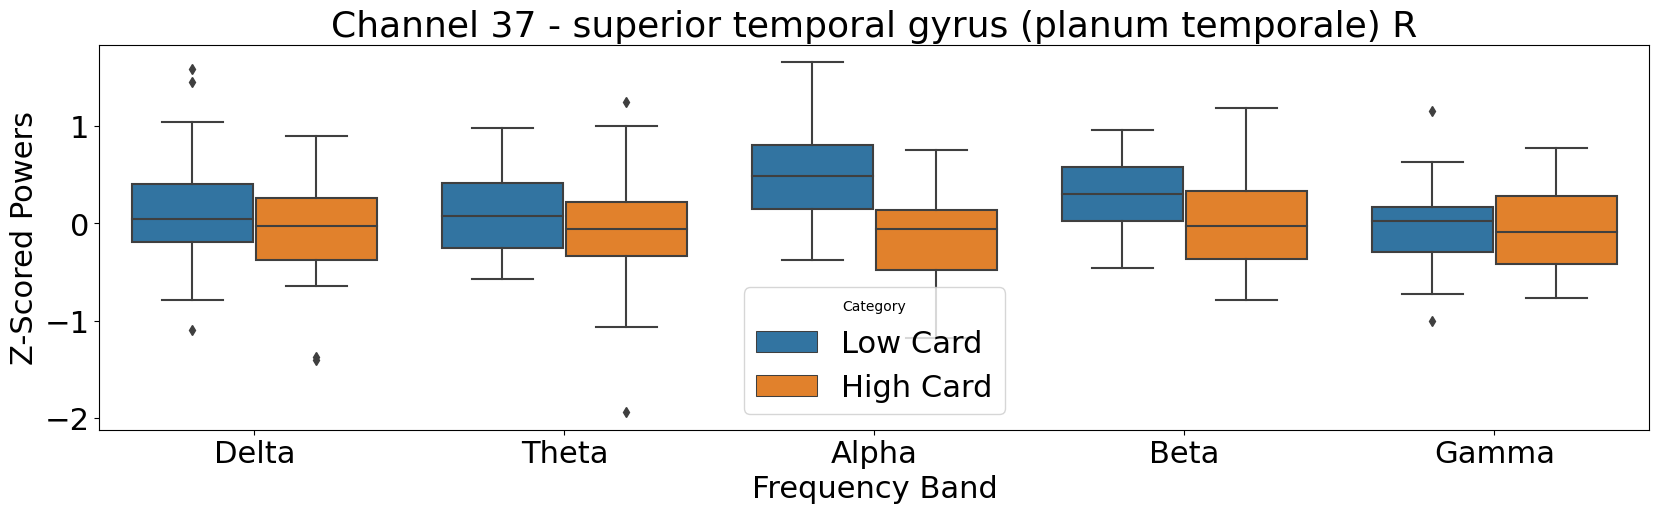

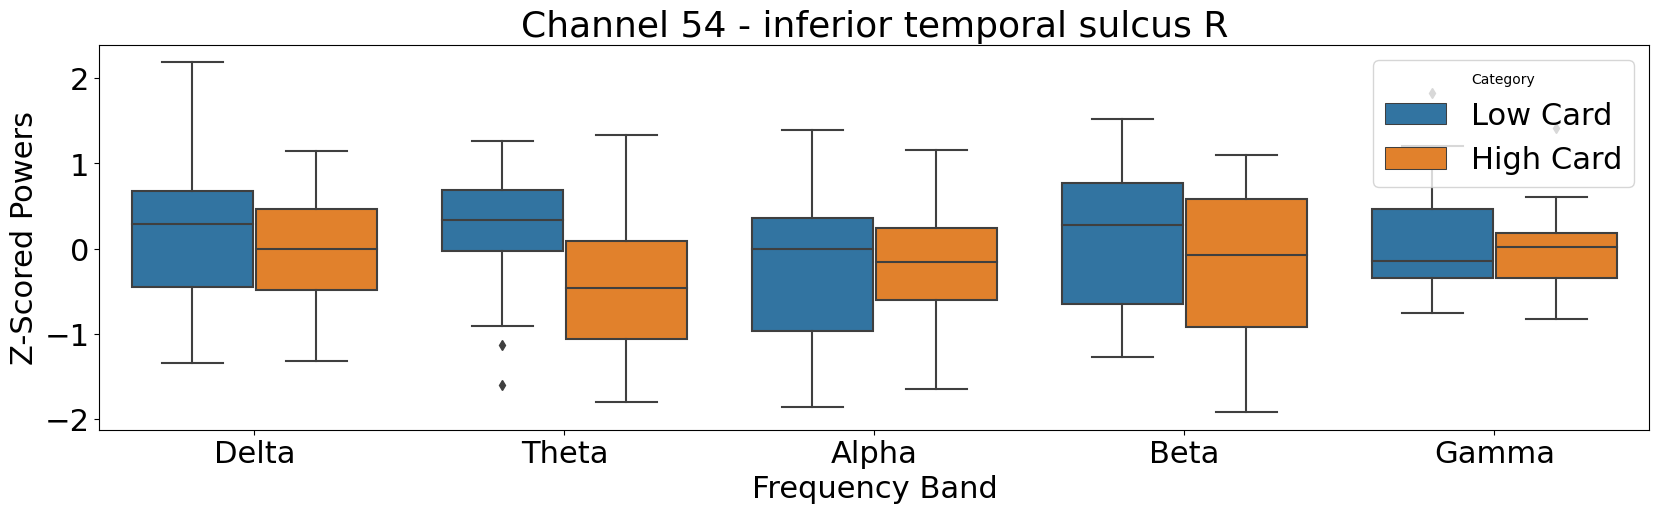

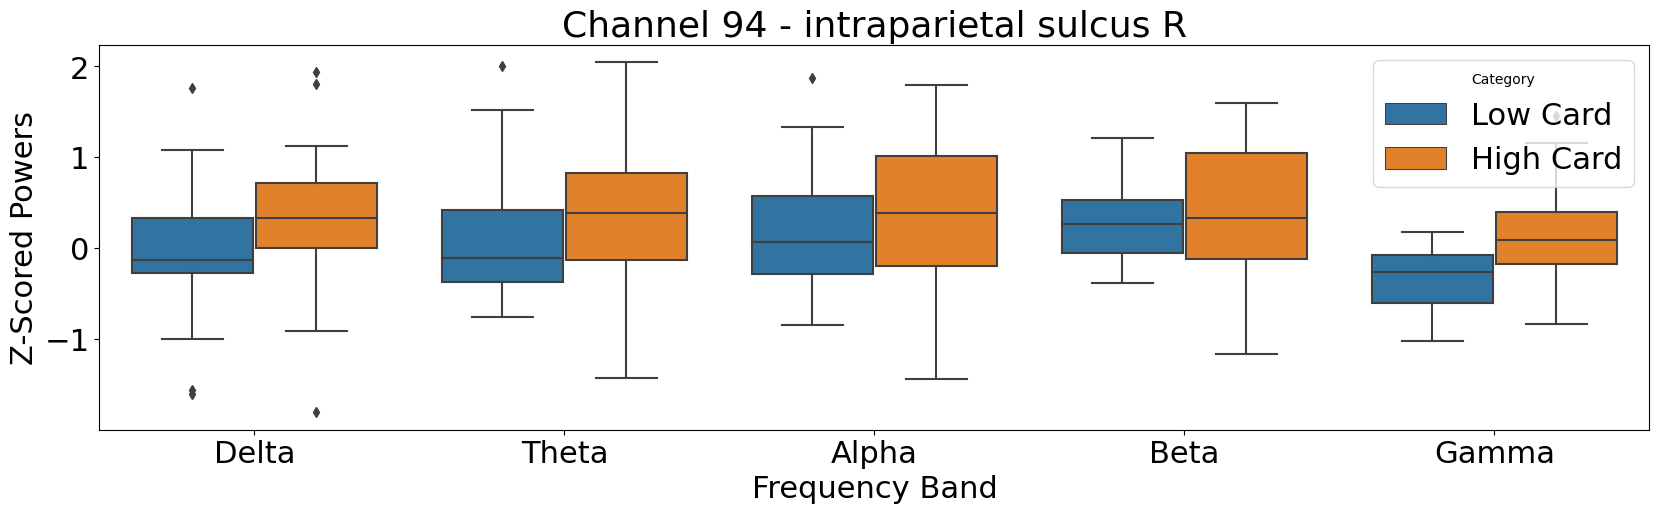

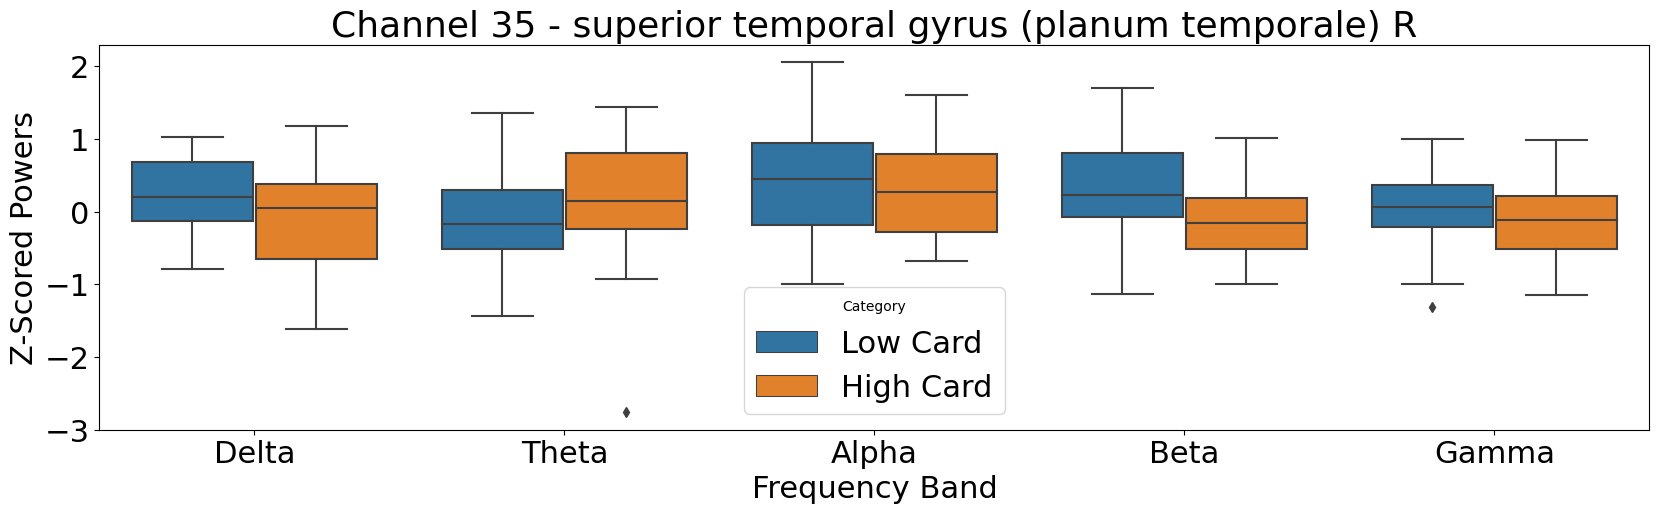

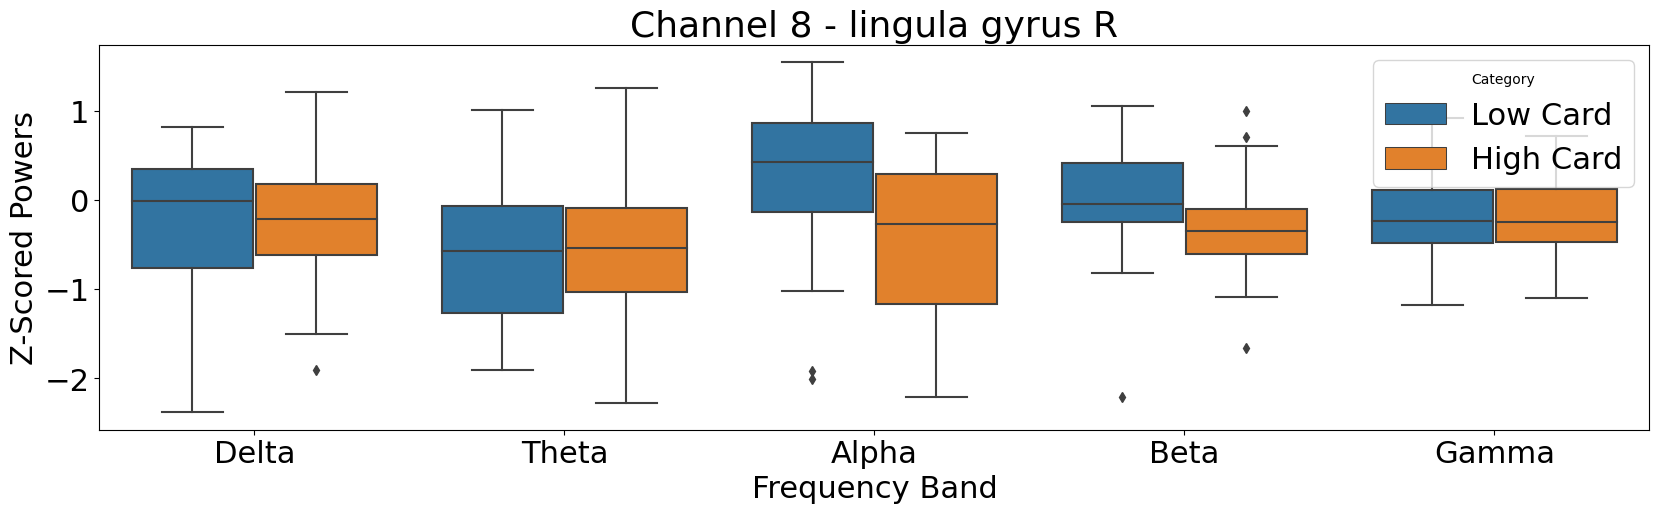

In [17]:
clf.plot_freq_box_plots(card_categories, optimal_channels[0], out_path_plots)

[35, 37, 54, 94, 8]


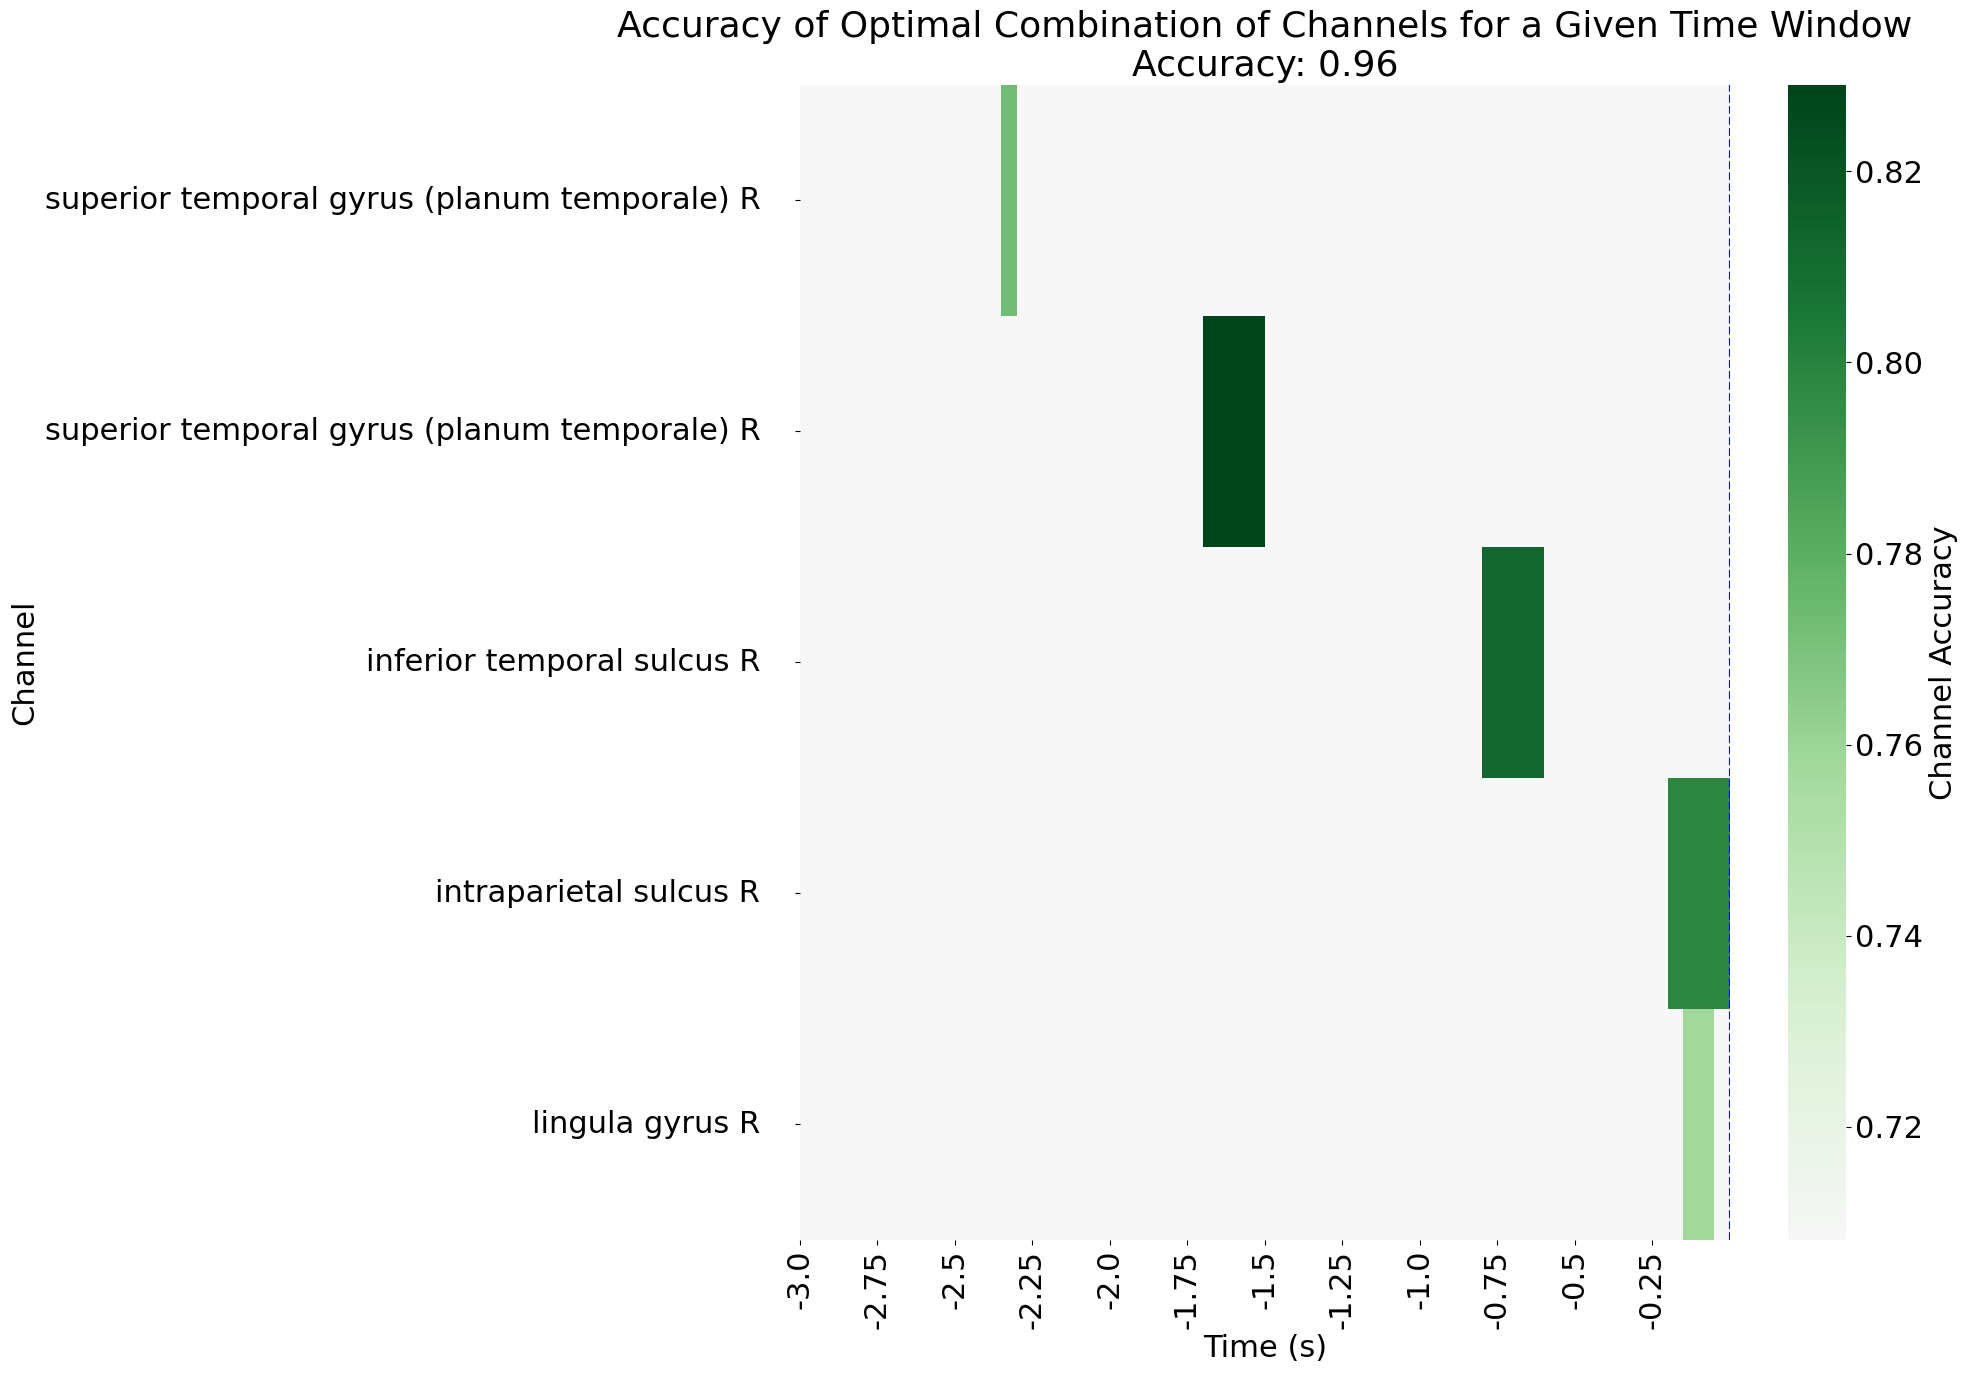

In [18]:
clf.plot_heatmap(optimal_channels[0], 3, optimal_channels[1], True, out_path_plots)

## Extraneous Code